# Run CAD model on real dataset<sup>1,2</sup>
### Dataset cannot be automatically downloaded, please sign data use agreement here: https://physionet.org/content/ct-ich/1.3.1/

1. Hssayeni, M. (2020). Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation (version 1.3.1). PhysioNet. https://doi.org/10.13026/4nae-zg36.
2. Goldberger, A., et al (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [1]:
# load and create dataframes

import os
import sys
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

from image_utils import *
from model_utils import *

path = Path('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/') # TODO: change directory
scan_path = Path.joinpath(path, 'ct_scans')

# load a modified version of Patient_demographics with cleaner headers
df = pd.read_csv('../datasets/MODIFIED_Patient_demographics.csv')
df = df.drop(df.columns[4:], axis=1) # remove lesion types
df.loc[df['Any_ICH'] != 0, 'Any_ICH'] = 1 # change # of ICH subtypes to binary 1/0
df['Model_Output'] = np.nan # add model output column

# there are six patients in Patient_demographics.csv with no images in the dataset; remove them
no_ct = [59, 60, 61, 61, 62, 63, 64, 65]
for case in no_ct:
    df.drop(df[df['Patient Number'] == case].index, inplace=True)
df.reset_index(drop=True, inplace=True)

/home/jayse.weaver/anaconda3/envs/insilicoich/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 101] Network is unreachable>
  data = fetch_version_info()


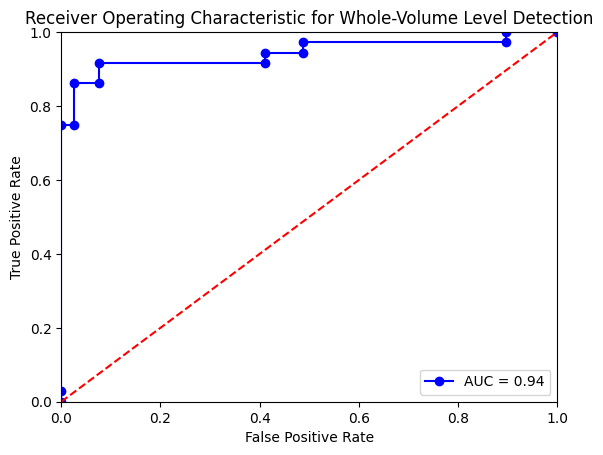

In [2]:
# Run CAD on real data
label_cols = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
options = {
    'size': (480, 480),
    'save_jpg': False,
    'save_csv': True,
    'verbose': False,
    'native_resolution': True
}

if os.path.isfile('real_dataset_predictions.csv'):
    df = pd.read_csv('real_dataset_predictions.csv')
else:
    with tqdm(total=len(df)) as pbar:
        for index, row in df.iterrows():

            nifti_path = Path.joinpath(scan_path, str(row['Patient Number']).zfill(3) + '.nii') #row['Patient Number']
            #print('Processing: ' + str(nifti_path))

            try:
                img, files = prepare_images(nifti_path, options, str(row['Patient Number']).zfill(3), 'saved_images/')

                output = classify_images(img, options)
                
                df.loc[index, 'Model_Output'] = np.max(output[:, -1]) # right now just want max value in the "any" category
            except:
                print('error')

    if options['save_csv']:
        df.to_csv('real_dataset_predictions.csv')

results_real = df[["Any_ICH", "Model_Output"]].to_numpy()

# Get ROC
fpr_real, tpr_real, thresholds_real = metrics.roc_curve(df["Any_ICH"].to_numpy(), df["Model_Output"].to_numpy(), pos_label=1)
roc_df_real = pd.DataFrame(zip(fpr_real, tpr_real, thresholds_real),columns = ["FPR","TPR","Threshold"])

roc_auc = metrics.auc(fpr_real, tpr_real)

plt.title('Receiver Operating Characteristic for Whole-Volume Level Detection')
plt.plot(fpr_real, tpr_real, 'bo-', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Run CAD model on synthetic datasets

In [ ]:
options = {
    'size': (480, 480),
    'save_jpg': False,
    'save_csv': True,
    'verbose': False,
    'native_resolution': False # synthetic data is 1 mm, "True" will reformat to 5 mm
}